# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 23.11.2019

Мягкий дедлайн: 8:00MSK 01.12.2019

Жесткий дедлайн: 23:59MSK 02.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style="darkgrid")

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.63405805982582

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    size = X.shape[0]
    used_counts = np.zeros(size, dtype=np.int32)
    pred_sum = np.zeros(size, dtype=np.float64)
    pred_squared = np.zeros(size, dtype=np.float64)
    pred_err_squared = np.zeros(size, dtype=np.float64)
    
    for i in range(num_runs):
        mask = np.zeros(size, dtype=np.bool)
        mask[np.random.randint(size, size=size)] = True
        model = regressor.fit(X[mask], y[mask])
        
        predict = model.predict(X[~mask])
        
        pred_sum[~mask] += predict
        pred_squared[~mask] += np.square(predict)
        pred_err_squared[~mask] += np.square(predict - y[~mask])
        
        used_counts[~mask] += 1
    used = used_counts != 0
    bias = np.mean(np.square(pred_sum[used] / used_counts[used] - y[used]))
    variance = np.mean(pred_squared[used] / used_counts[used] - np.square(pred_sum[used] / used_counts[used])) 
    error = np.mean(pred_err_squared[used] / used_counts[used])
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

regressors = { 
    'LinearRegression': LinearRegression(), 
    'DecisionTreeRegressor': DecisionTreeRegressor(), 
    'RandomForestRegressor': RandomForestRegressor()
}

n_runs = 1500

for name, regressor in regressors.items():
    bias, variance, error = compute_biase_variance(regressor, X, y, num_runs=n_runs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    regressor.fit(X_train, y_train)
    print('Name:', name)
    print('Bias:', bias)
    print('Variance:', variance)
    print('Error:', error)
    print('Diff:', abs(error - bias - variance), '\n')

Name: LinearRegression
Bias: 23.747084837843524
Variance: 0.5981775227223605
Error: 24.345262360565858
Diff: 2.5979218776228663e-14 

Name: DecisionTreeRegressor
Bias: 10.763897409104386
Variance: 12.639604356705235
Error: 23.403501765809935
Diff: 3.1441516057384433e-13 

Name: RandomForestRegressor
Bias: 11.092649153615636
Variance: 2.7524342988960595
Error: 13.845083452511627
Diff: 6.794564910705958e-14 



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ Согласуются.

Смещение показывает, как хорошо с помощью  разных методов обучения и семейств алгоритмов можно приблизить оптимальный алгоритм. Маленькое смещение у сложных семейств, большое - у более простых.

Дисперсия показывает, как сильно может изменяться ответ обученного алгоритма в зависимости от выборки, т.е. она показывает чувствительность метода обучения к изменениям в выборке. Как правило, простые семейства имеют маленькую дисперсию, а сложные — большую дисперсию.

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__  Нет, т. к. выборки очень большие и они коррелируют между собой. В теории бутстрап уменьшает разброс в num_runs раз, но не на практике.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [9]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    size = X_train.shape[0]
    for i in range(num_runs):
        mask = np.zeros(size, dtype=bool)
        mask[np.random.randint(size, size=size)] = True
        regressor.fit(X_train[mask], y_train[mask])
        plt.scatter(np.arange(num_test_objects), regressor.predict(X_test), c='blue')
    plt.scatter(np.arange(num_test_objects), y_test, c='red')
    plt.title(title)
    plt.xlabel("Num test object")
    plt.ylabel("Prediction")

__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

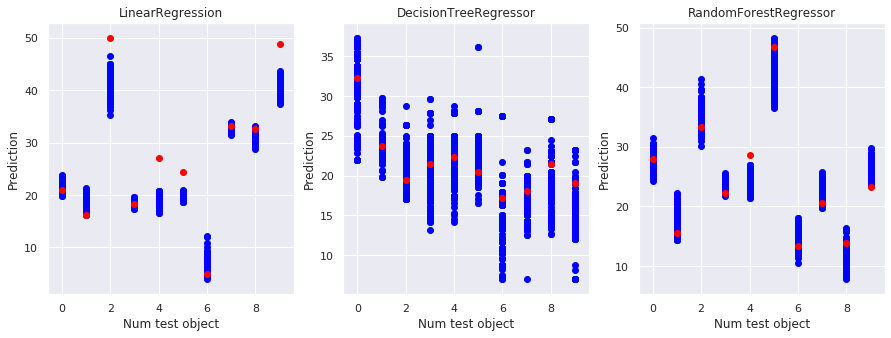

In [10]:
plt.figure(figsize=(15, 5))

for i, (name, regressor) in enumerate(regressors.items()):
    plt.subplot(1, 3, i + 1)
    plt.grid(color='w')
    plot_predictions(regressor, X, y, title=name, num_runs=500)

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Большое смещение у LinearRegression с сравнительно небольшим разбросом. Для двух других графиков ситуация противоположная. Как описано выше, эти результаты вполне логичны.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

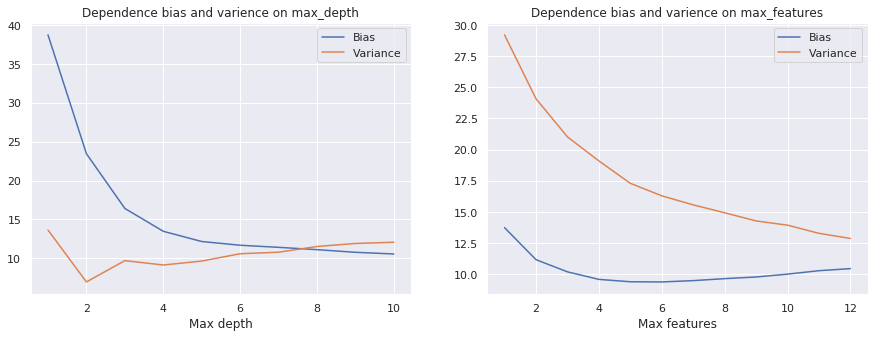

In [11]:
max_depths = np.arange(1, 11)
max_features = np.arange(1, X.shape[1])

biases = np.array([])
variances = np.array([])

for max_depth in max_depths:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y) 
    
    biases = np.append(biases, bias)
    variances = np.append(variances, variance)

plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1)  
plt.plot(max_depths, biases, label='Bias')
plt.plot(max_depths, variances, label='Variance')
plt.grid(color='w')
plt.title('Dependence bias and varience on max_depth')
plt.xlabel('Max depth')
plt.legend()

biases = np.array([])
variances = np.array([])

for max_feature in max_features:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=max_feature), X, y) 
    
    biases = np.append(biases, bias)
    variances = np.append(variances, variance)

plt.subplot(1, 2, 2)  
plt.plot(max_features, biases, label='Bias')
plt.plot(max_features, variances, label='Variance')
plt.xlabel('Max features')
plt.legend()
plt.grid(color='w')
plt.title('Dependence bias and varience on max_features')
plt.show()

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

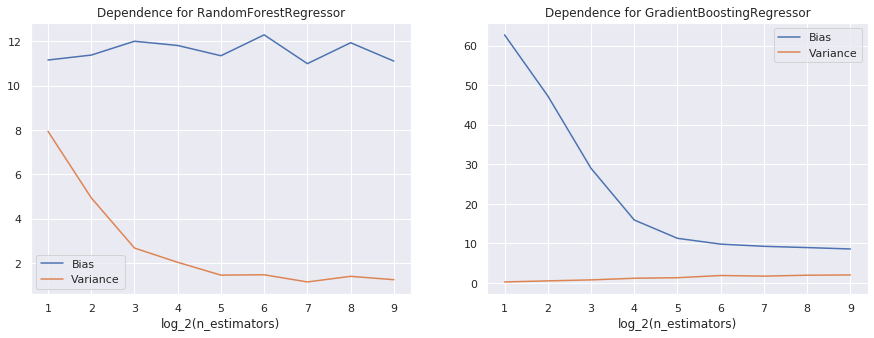

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators = np.arange(1, 10)

biases_random = np.array([])
variances_random = np.array([])

biases_gradient = np.array([])
variances_gradient = np.array([])

for n in n_estimators:
    bias, variance, error = compute_biase_variance(
        RandomForestRegressor(n_estimators=2 ** n), X, y, num_runs=30
    ) 
    
    biases_random = np.append(biases_random, bias)
    variances_random =  np.append(variances_random, variance)
    
    bias, variance, error = compute_biase_variance(
        GradientBoostingRegressor(n_estimators=2 ** n), X, y, num_runs=30
    ) 
    
    biases_gradient = np.append(biases_gradient, bias)
    variances_gradient = np.append(variances_gradient, variance)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators, biases_random, label='Bias')
plt.plot(n_estimators, variances_random, label='Variance')
plt.xlabel('log_2(n_estimators)')
plt.legend()
plt.grid(color='w')
plt.title('Dependence for RandomForestRegressor')

plt.subplot(1, 2, 2)
plt.plot(n_estimators, biases_gradient, label='Bias')
plt.plot(n_estimators, variances_gradient, label='Variance')
plt.xlabel('log_2(n_estimators)')
plt.legend()
plt.grid(color='w')
plt.title('Dependence for GradientBoostingRegressor')
plt.show()

__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

На первых двух графиках при увеличении параметров структура становится сложнее и гибче для входных данных, поэтому ошибки монотонно убывают. Но т. к. это ансамбли, с определенного промежутка есть эффект переобучения, и ошибка снова начинает расти.

На следующих двух до определенного момента ошибки уменьшаются, т. к. снова структура модели станоится гибче, и она подгоняет нашу зависимость. С ростом N крайние деревья начинают терять свою функциональность и настраиваются на шум, поэтому ошибки выходят на постоянный уровень.